In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from qopt import lecroy
import os

In [2]:
#Functions
def compare(value, list0):
    x = max(list0)
    if x >= value:
        return 1
    else:
        return 0

# Load data

<ipython-input-3-7ca796b03aba>:9: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
  click_file = sp.array([os.path.join(path, f) for f in sorted(os.listdir(path)) if 'click' in f])
<ipython-input-3-7ca796b03aba>:10: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
  eom_file = sp.array([os.path.join(path, f) for f in sorted(os.listdir(path)) if 'eom' in f])


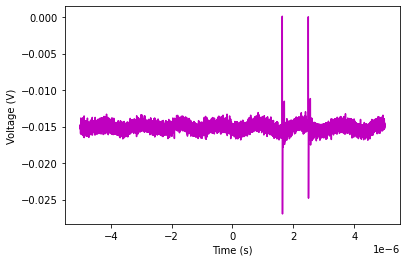

In [3]:
#SSPD signals should be named 'click' + '[value on matlab sent to EOM]' + '.trc'
#EOM signals should be saved with 'eom' on name

date = '20230202//'
extra = 'data//'

path = os.path.join(date, extra)

click_file = sp.array([os.path.join(path, f) for f in sorted(os.listdir(path)) if 'click' in f])
eom_file = sp.array([os.path.join(path, f) for f in sorted(os.listdir(path)) if 'eom' in f])

matlab_set_str = []
for i in range(len(click_file)):
    click_name = click_file[i].find('click') + len('click')
    ext_name = click_file[i].find('.trc')
    matlab_set_str.append(click_file[i][click_name:ext_name])
matlab_set_int = []
for k, name in enumerate(matlab_set_str):
    if name == 'fake':
        matlab_set_int.append(0)
    else:
        matlab_set_int.append(int(matlab_set_str[k]))
max_set_index = matlab_set_int.index(max(matlab_set_int))
fake_index = [k for k, val in enumerate(click_file) if 'fake' in val][0]

_click_data = []
click_data = []
eom_data = []
for j in range(len(click_file)):
    _click_data.append(lecroy.read(click_file[j]))
    click_data.append(lecroy.read(click_file[j])[2])
    eom_data.append(lecroy.read(eom_file[j])[2])
    
metadata = _click_data[0][0]
        
Ts = metadata['horiz_interval']
all_points = metadata['wave_array_count']
sequences = metadata['subarray_count']
points_per_seq = int(all_points/sequences)
horiz_offset = metadata['horiz_offset']
time = np.linspace(horiz_offset, horiz_offset + points_per_seq*Ts, points_per_seq)

test_data = max_set_index
test_sequence = 30
plt.figure()
plt.plot(time, click_data[test_data][test_sequence], 'm')
#plt.plot(time, eom_data[test_data][test_sequence], 'c')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.show()

# Find EOM peaks

In [4]:
beta = True
eom_peaks = []

eom_mean = np.mean(eom_data[max_set_index][0])
value_above_mean = 0.1

peak_index = next(k for k, val in enumerate(eom_data[max_set_index][0]) if val > eom_mean + value_above_mean)
eom_peaks.append(peak_index)

if beta:
    between_index = int(7*10**(-7)/Ts)
    peak_index += between_index + next(k for k, val in enumerate(eom_data[max_set_index][0][(peak_index+between_index):]) if val > eom_mean + value_above_mean)
    eom_peaks.append(peak_index)
    
for index in eom_peaks:
    peak_time = (horiz_offset + index*Ts)*10**9
    print('Peak time: ', peak_time, "ns")

Peak time:  1540.2471642389858 ns
Peak time:  2340.2471749201313 ns


# Find photon clicks

In [5]:
delay_time = 900 #ns
delay_points = int(delay_time*10**(-9)/Ts)

window_time = 200 #ns
window_points = int(window_time*10**(-9)/Ts)

clicks = np.zeros(len(click_data))

click_mean = np.mean(click_data[fake_index][0])

for i in range(len(click_data)):
    for j in range(len(eom_peaks)):
        start = eom_peaks[j] + delay_points - int(window_points/2)
        stop = start + int(window_points)
        for k in range(len(click_data[i])):
            clicks[i] += compare(0.005 + click_mean, click_data[i][k][start:stop])
print(clicks)

click_rate = [a/(2*len(click_data[0])) for a in clicks]
click_percent = [100*x for x in click_rate]
print(click_rate)

[116. 434. 484. 500. 143. 161. 196. 239. 263. 306. 372. 411. 117.]
[0.058, 0.217, 0.242, 0.25, 0.0715, 0.0805, 0.098, 0.1195, 0.1315, 0.153, 0.186, 0.2055, 0.0585]


In [6]:
alpha_amp = 0.4
beta_amp = 0.665
alpha_percent = 100*(1 - np.exp(-alpha_amp**2))
beta_percent = 100*(1 - np.exp(-beta_amp**2))
print(alpha_percent/100, beta_percent/100)

0.14785621103378865 0.3573949669440664


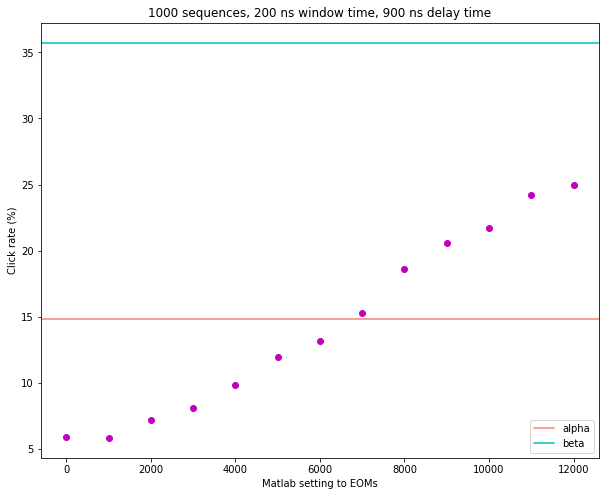

In [7]:
plt.figure(figsize = (10, 8))
plt.plot(matlab_set_int, click_percent, 'mo')
plt.axhline(y = alpha_percent, color = 'salmon', label = 'alpha')
plt.axhline(y = beta_percent, color = 'c', label = 'beta')
plt.xlabel('Matlab setting to EOMs')
plt.ylabel('Click rate (%)')
plt.title(str(sequences) + ' sequences, ' + str(window_time) + ' ns window time, ' + str(delay_time) + ' ns delay time')
plt.legend()
plt.tight_layout
plt.savefig(os.path.join(date, 'figures//', str(window_time) + 'wt_clickrate'), dpi = 1000)
plt.show()